# Multi-Layer Perceptron, MNIST
---
In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [3]:
# import libraries
import torch
import numpy as np

---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [16]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

In [17]:
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [18]:
num_train, len(train_idx), len(valid_idx)

(60000, 48000, 12000)

In [13]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [14]:
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [32]:
(len(train_data), len(train_loader.dataset), 
 len(valid_loader.dataset), 
 len(test_data), len(test_loader.dataset))

(60000, 60000, 60000, 10000, 10000)

In [26]:
len(train_loader), len(valid_loader), len(test_loader)

(1500, 375, 313)

In [24]:
len(train_loader)*batch_size, len(valid_loader)*batch_size, len(test_loader)*batch_size

(48000, 12000, 10016)

### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

In [33]:
force_cpu = False
device = torch.device("cuda" if torch.cuda.is_available() and not force_cpu else "cpu")
device 

device(type='cuda')

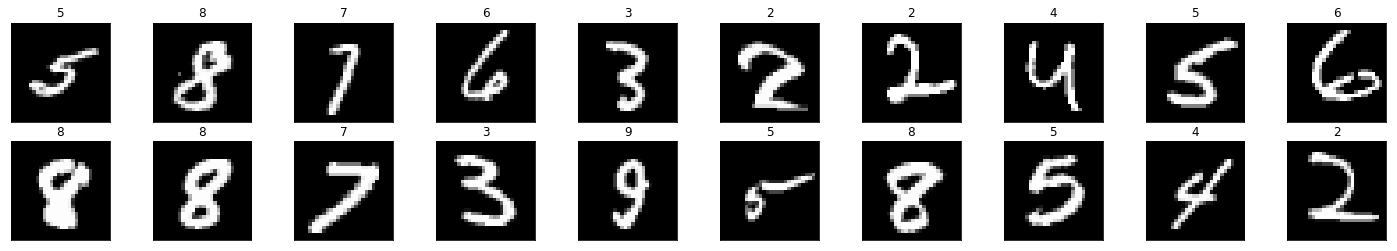

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

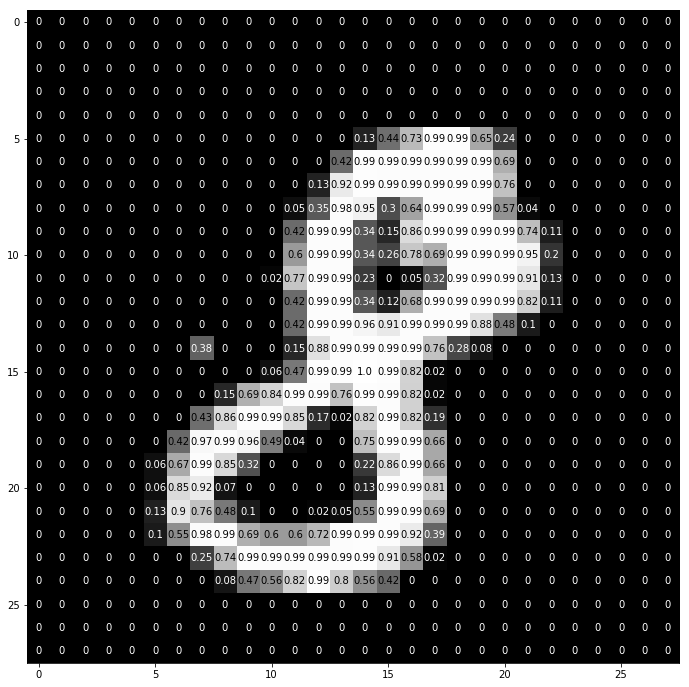

In [35]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

## TODO: Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # linear layer (784 -> 1 hidden node)
        hidden_1 = 512
        hidden_2 = 512

        self.fc1 = nn.Linear(28 * 28, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [58]:
del model

In [59]:
# initialize the NN
model = Net()
model.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer *and* then calculates the log loss.

In [50]:
## TODO: Specify loss and optimization functions

# specify loss function
criterion = nn.CrossEntropyLoss()

# Note: CrossEntropyLoss first applies a softmax function to any output is sees
#       Then applies NLLLoss; negative log likelihood loss

# Alternatively if declaring criterion = nn.NLLLoss()
# then In the forward function of our model, we would explicitly 
# apply a softmax activation function to the output, x.
# x = F.log_softmax(x, dim=1)

# Learning Rate finder

In [38]:
# Starting point for learning rate finder
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

In [42]:
import math

def find_lr(model, optimizer, init_value = 1e-8, final_value=10., beta = 0.98):
    num = len(train_loader)-1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    
    for images, labels in train_loader:
        batch_num += 1
        
        #Get the loss for this mini-batch of images/outputs
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        output = model.forward(images)
        
        loss = criterion(output, labels)
        
        #Compute the smoothed loss
        avg_loss = beta * avg_loss + (1-beta) * loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        
        #Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        
        #Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        
        #Store the values
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        
        #Do the SGD step
        loss.backward()
        optimizer.step()
        
        #Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
    
    return log_lrs, losses

In [43]:
logs,losses = find_lr(model, optimizer)

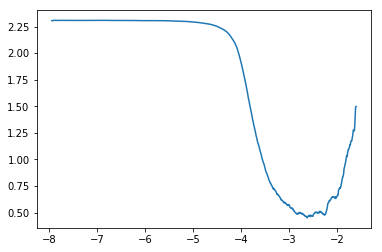

In [44]:
plt.plot(logs[10:-5],losses[10:-5])

In [45]:
print("{:5f}".format(1e-4))

0.000100


In [60]:
# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

The following loop trains for 30 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data. 

**Use next cell if loading previously saved model, instead of re-training...**

In [61]:
# number of epochs to train the model
n_epochs = 30  # suggest training between 20-50 epochs

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

train_losses, valid_losses = [], []

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # Put data and target on to gpu if available
        data, target = data.to(device), target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        
        # Put data and target on to gpu if available
        data, target = data.to(device), target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)

    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    # add the losses to list of all losses
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        
        torch.save(model.state_dict(), 'mnist_mlp_epoch_'+str(epoch+1)+'.pt')
        valid_loss_min = valid_loss    

Epoch: 1 	Training Loss: 0.408127 	Validation Loss: 0.049595
Validation loss decreased (inf --> 0.049595).  Saving model ...
Epoch: 2 	Training Loss: 0.181602 	Validation Loss: 0.036328
Validation loss decreased (0.049595 --> 0.036328).  Saving model ...
Epoch: 3 	Training Loss: 0.134202 	Validation Loss: 0.028686
Validation loss decreased (0.036328 --> 0.028686).  Saving model ...
Epoch: 4 	Training Loss: 0.104616 	Validation Loss: 0.023389
Validation loss decreased (0.028686 --> 0.023389).  Saving model ...
Epoch: 5 	Training Loss: 0.084966 	Validation Loss: 0.019553
Validation loss decreased (0.023389 --> 0.019553).  Saving model ...
Epoch: 6 	Training Loss: 0.069947 	Validation Loss: 0.017419
Validation loss decreased (0.019553 --> 0.017419).  Saving model ...
Epoch: 7 	Training Loss: 0.059143 	Validation Loss: 0.016480
Validation loss decreased (0.017419 --> 0.016480).  Saving model ...
Epoch: 8 	Training Loss: 0.049860 	Validation Loss: 0.015472
Validation loss decreased (0.01648

In [62]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

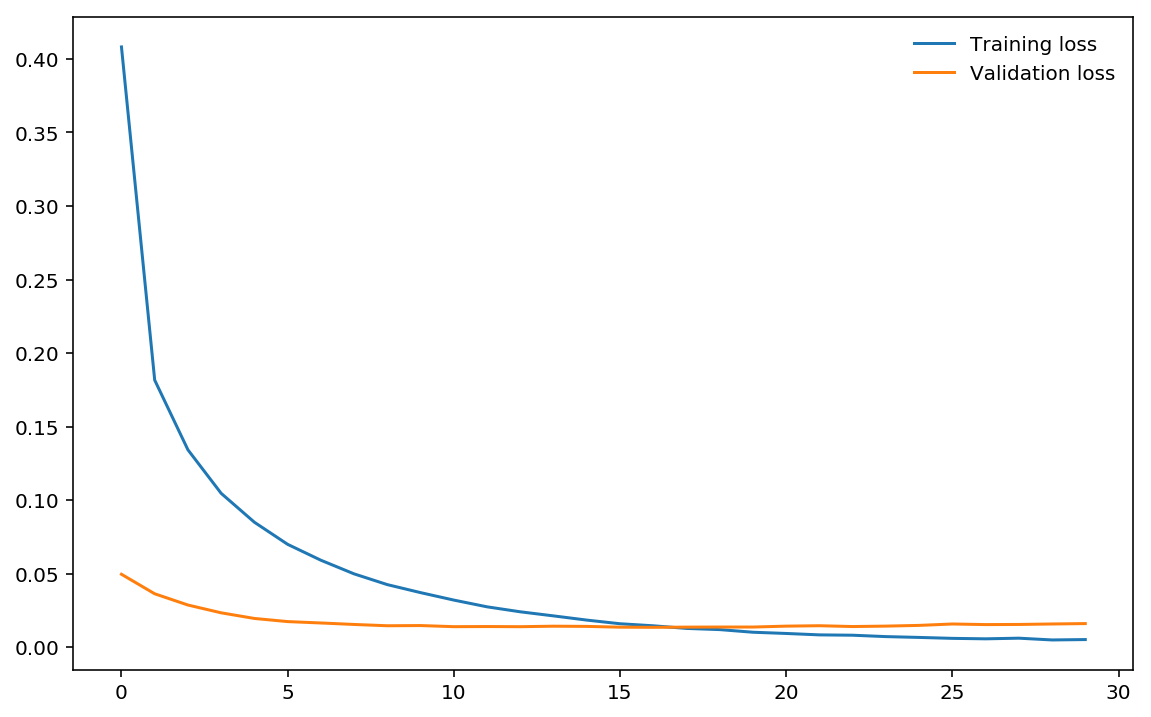

In [63]:
plt.rcParams['figure.figsize'] = [9.5, 6]

plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend(frameon=False)
plt.show()

###  Load the Model with the Lowest Validation Loss

**Best model this round was at epoch 17, load it then save this as the early stopping model...**

In [65]:
state_dict = torch.load('mnist_mlp_epoch_17.pt')
model.load_state_dict(state_dict)

In [66]:
torch.save(model.state_dict(), 'mnist_mlp_early_stopping_checkpoint.pth')

---
## Test the Trained Network

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

#### `model.eval()`

`model.eval(`) will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation!

In [67]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    
    data, target = data.to(device), target.to(device)
        
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        if target.data.size(0) > i:    
            if torch.cuda.is_available():
                label = target.data[i].cpu()
                class_correct[label] += correct[i].cpu().item()
            else:
                label = target.data[i]
                class_correct[label] += correct[i].item()

            class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %.1f%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %.1f%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.067562

Test Accuracy of     0: 99.0% (970/980)
Test Accuracy of     1: 98.9% (1123/1135)
Test Accuracy of     2: 98.4% (1016/1032)
Test Accuracy of     3: 98.4% (994/1010)
Test Accuracy of     4: 98.0% (962/982)
Test Accuracy of     5: 98.1% (875/892)
Test Accuracy of     6: 98.1% (940/958)
Test Accuracy of     7: 97.0% (997/1028)
Test Accuracy of     8: 97.5% (950/974)
Test Accuracy of     9: 98.1% (990/1009)

Test Accuracy (Overall): 98.2% (9817/10000)


Previous result before using the validation set and reloading best weights...
```
Test Loss: 0.071299

Test Accuracy of     0: 99.3% (973/980)
Test Accuracy of     1: 99.0% (1124/1135)
Test Accuracy of     2: 98.2% (1013/1032)
Test Accuracy of     3: 97.7% (987/1010)
Test Accuracy of     4: 98.4% (966/982)
Test Accuracy of     5: 98.7% (880/892)
Test Accuracy of     6: 98.1% (940/958)
Test Accuracy of     7: 98.2% (1009/1028)
Test Accuracy of     8: 97.3% (948/974)
Test Accuracy of     9: 97.4% (983/1009)

Test Accuracy (Overall): 98.2% (9823/10000)
```

### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

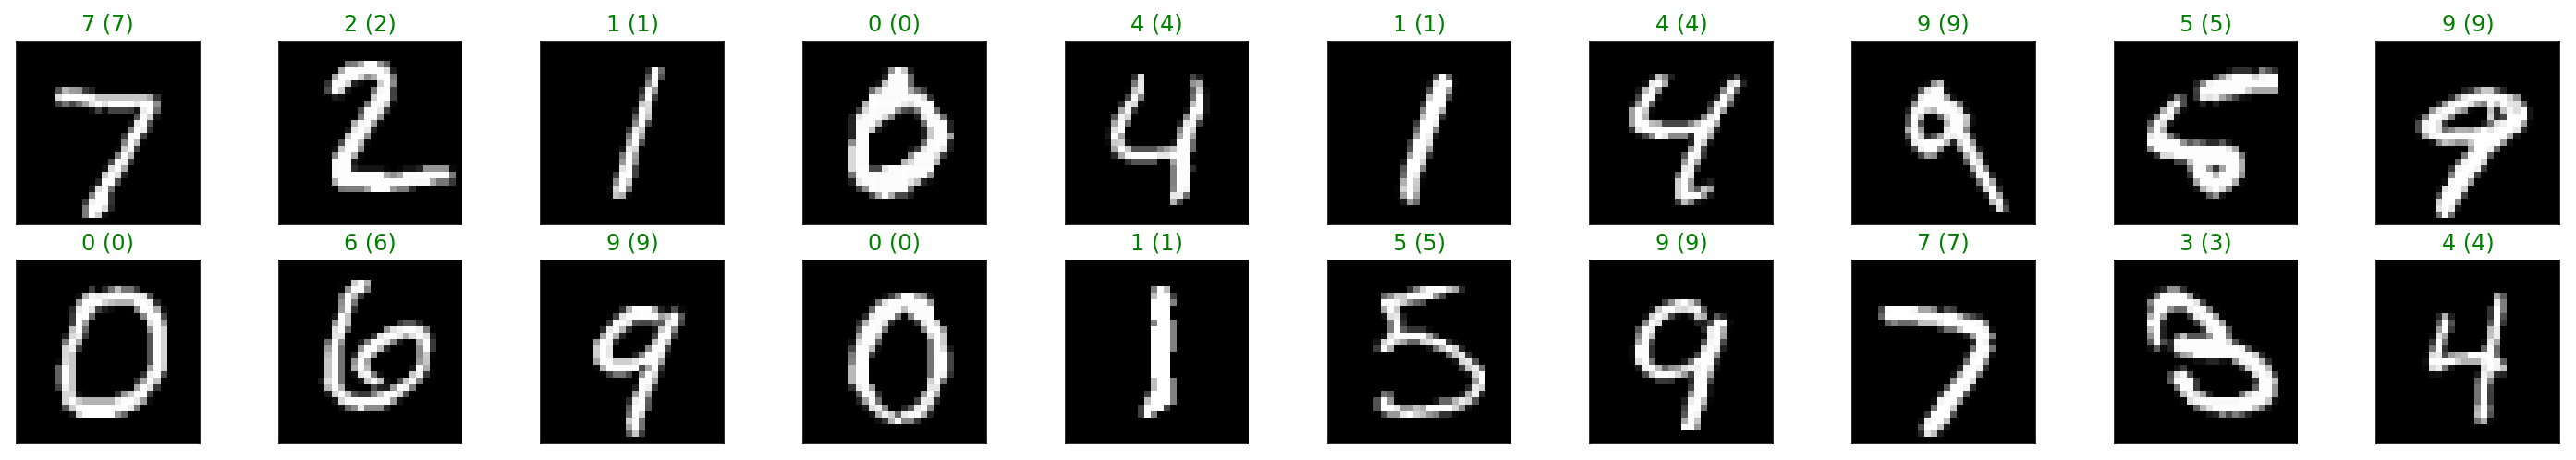

In [69]:
# obtain one batch of test images
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(test_loader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))